# Maps rendering
This homework and the associated maps can be visualised [here (NBviewer)](http://nbviewer.jupyter.org/github/adamkozak/ADA2017-project/blob/master/Homework/03%20-%20Interactive%20Viz/03%20-%20Interactive%20Viz.ipynb).

# Question 1
# Unemployment rate in Europe

#### Import libraries

In [1]:
import os
import pandas as pd
import json
import folium
from topojson import geometry
import vincent
import copy

pd.set_option('mode.chained_assignment', None)

#### Load TopoJson file with Europe topography

In [2]:
europe_geo_path = os.path.join('topojson', 'europe.topojson.json')
europe_json_data = json.load(open(europe_geo_path))

#### Create map with origin in the middle of Europe

In [3]:
m = folium.Map([48.1176609, 4.0804824], tiles='cartodbpositron', zoom_start=4)

#### Load data from Eurostat
We decided to use the harmonized unemployment rate (HUR):
> Harmonised unemployment rates define the unemployed as people of working age who are without work, are available for work, and have taken specific steps to find work. The uniform application of this definition results in estimates of unemployment rates that are more internationally comparable than estimates based on national definitions of unemployment. This indicator is measured in numbers of unemployed people as a percentage of the labour force and it is seasonally adjusted. The labour force is defined as the total number of unemployed people plus those in civilian employment.

> [Source](https://data.oecd.org/unemp/harmonised-unemployment-rate-hur.htm)

+ The colors in the map will be based on data from July 2017 (because there is no data for several countries from August and Semptember). 
+ Every missing data is replace with 0, as unemployment rate can't reach that level.
+ Switzerland data had to be inserted, as Eurostat does not provide data about Swiss HUR.

In [4]:
eurostat = pd.read_csv('./data/eurostat_ilo_definition.csv')
eurostat = eurostat[['TIME', 'GEO', 'GEO_LABEL', 'Value']]
eurostat['Value'] = eurostat['Value'].str.replace(":", "0").astype("float")

# Add Switzerland data to dataframe
eurostat.loc[eurostat['GEO'] == 'DE', 'GEO_LABEL'] = 'Germany'
swiss_HUR = [3.7, 3.6, 3.4, 3.3, 3.1, 3, 3, 3, 3]
swiss_df = eurostat.loc[eurostat['GEO'] == 'DE', :]
swiss_df['GEO'] = 'CH'
swiss_df['GEO_LABEL'] = 'Switzerland'
swiss_df['Value'] = swiss_HUR

eurostat = pd.concat([eurostat, swiss_df], ignore_index = True)

# Extract only data from July to use for choropleth
eu_07 = eurostat.loc[eurostat['TIME'] == '2017M07', :]
max_eurostat = max(eurostat['Value'].values)

#### Definitions of used function

In [5]:
def get_monthly_data(country):
    """Get data about one particular country from Eurostat DataFrame"""
    df = eurostat.loc[eurostat.GEO_LABEL == country, :][["TIME", 'Value']]
    df = df.set_index("TIME")
    return df

def create_barchart(df):
    """Create bar chart based on DataFrame"""
    bar_chart = vincent.Bar(df, width=400, height=190)
    bar_chart.axis_titles(y = 'Unemployment rate (%)', x = 'Date')
    
    # Set properties for x-axis
    ax = vincent.AxisProperties(labels = vincent.PropertySet(angle=vincent.ValueRef(value=30), 
                                                             dx=vincent.ValueRef(value=10),
                                                             font_size=vincent.ValueRef(value=9)
                                                             ))
    bar_chart.axes[0].properties = ax   
    # Set y-axis maximal domain value as the highest value in the Eurostat Dataframe
    bar_chart.scales[1].domain_max = max_eurostat
    # Padding between bars
    bar_chart.scales[0].padding = 0.2
    #Grid on
    bar_chart.axes[1].grid = True
    return bar_chart

#### Create a basic choropleth 
Choropleth was build according to Eurostat data from September 2017

In [6]:
m.choropleth(
    geo_data=europe_json_data,
    data=eu_07,
    columns=['GEO_LABEL', 'Value'],
    key_on='feature.properties.NAME',
    fill_color='YlGn',
    fill_opacity=0.6,
    line_opacity=0.2,
    legend_name='Unemployment Rate (%)',
    topojson = 'objects.europe',
    threshold_scale = [1, 3, 6, 10, 14, 20]
)

#### Popups and charts
Here we used function from external library to calculate coordinates of countries borders, as TopoJson file provides only delta-encoded values [TopoJson Wiki](https://github.com/topojson/topojson-specification/blob/master/README.md#213-arcs). We do NOT convert the TopoJson file to GeoJson file. Moreover at the end there is a solution using the TopoJson method, but it is not very efficient and may cause web browser freezes.

+ Having coordinates of each country we add a popup with a bar chart of HUR during that year or if there is no such data, we simply add popup with text information. 
+ Moreover countries without the data are colored in white color.
+ Countries (for example Great Britain) for which there is no data from September are also colored in white (but when you click on them you will see a chart containing values for the previous months).

In [7]:
features = europe_json_data['objects']['europe']['geometries']
scale = europe_json_data['transform']['scale']
trans = europe_json_data['transform']['translate']

### Version with GeoJson

In [8]:
for idx, feature in enumerate(features): 
    if feature['properties']['NAME'] in eurostat.GEO_LABEL.values:
        tmp = folium.GeoJson(data = geometry(feature, europe_json_data['arcs'], scale, trans), 
                         style_function = lambda x: {
                                                            'fillColor': '#e66101',
                                                            'fillOpacity' : 0.0,
                                                            'opacity' : 0.0,
                                                          })
    
        tmp.add_child(folium.Popup(max_width=450).
                      add_child(folium.Vega(create_barchart(get_monthly_data(feature['properties']['NAME'])), 
                                            width=450, height=250)))
    else:
        tmp = folium.GeoJson(data = geometry(feature, europe_json_data['arcs'], scale, trans), 
                         style_function = lambda x: {
                                                            'fillColor': '#ffffff',
                                                            'fillOpacity' : 0.2,
                                                            'opacity' : 0.0,
                                                          })
        tmp.add_child(folium.Popup('Lack of data'))
        
    tmp.add_to(m)

m

#### Version with TopoJson
It works, but if you try to close the popup it will freeze for a while, so we decided to look for some workaround.

In [9]:
#country_topojson = json.load(open(europe_geo_path))
#
#for feature in features:
#    country_topojson['objects']['europe']['geometries'] = [feature]
#    if feature['properties']['NAME'] in eurostat.GEO_LABEL.values:
#        tmp = folium.TopoJson(data = copy.deepcopy(country_topojson), object_path = 'objects.europe',  
#                         style_function = lambda x: {
#                                                            'fillColor': '#e66101',
#                                                            'fillOpacity' : 0.0,
#                                                            'opacity' : 0.0,
#                                                          })
#    
#        tmp.add_child(folium.Popup(max_width=450).
#                      add_child(folium.Vega(create_barchart(get_monthly_data(feature['properties']['NAME'])), 
#                                            width=450, height=250)))
#    else:
#        tmp = folium.TopoJson(data = copy.deepcopy(country_topojson), object_path = 'objects.europe', 
#                         style_function = lambda x: {
#                                                            'fillColor': '#e66101',
#                                                            'fillOpacity' : 0.2,
#                                                            'opacity' : 0.0,
#                                                          })
#        tmp.add_child(folium.Popup('Lack of data'))
#        
#    tmp.add_to(m)
#
#m

# Question 2 
# Amstat website

To start, let us draw a map of Switzerland with the overlay showing the different cantons. 

In [10]:
#Import the overlay needed to draw the different cantons
switz_geo_path = os.path.join('topojson', 'ch-cantons.topojson.json')
switz_json_data = json.load(open(switz_geo_path))

In [11]:
#create a map centered on Switzerland 
m_switz = folium.Map([46.7, 8.3], tiles='cartodbpositron', zoom_start=7)

#Add the overlay to the map
x_switz=folium.TopoJson(data = switz_json_data, object_path = 'objects.cantons')
x_switz.add_to(m_switz)


Then, the data from the amstat website must be downloaded. However, it is important to clarify what are our hypotheses concerning the definitons of each word used (unemployment, job seekers etc...).

4 columns have been extracted from the data of the amstat website, namely:
* 'taux de chômage'="rate of unemployment"
* 'demandeurs d'emploi'= "job seekers"
* 'chômeurs inscrit' = "unemployed"
* 'demandeurs d'emploi non chômeurs'="job seekers not unemployed"

The amstat website states that the "unemployment rate" ('taux de chomage') is calculated by dividing the number of "unemployed" people ('inscrits au chômage') by the "active population". Therefore we will consider that the first column does not account for the "job seekers not unemployed" ('demandeur d'emploi non inscrits au chômage').

The general "rate of job seekers" should be "job seekers"/"active population". Therefore, a column indicating the size of the "active population" is needed and can be computed using "active population"="unemployed"/"rate of unemployment". 

The job seekers and unemployment rates can then be compared.


In [12]:
#Import the excel data into a dataframe
DATA_FOLDER = 'data'
swiss_employ_df = pd.read_excel(DATA_FOLDER+"/Unemployed_job_seekers_by_month.xlsx")


In [13]:
#Erase the " ' " put for thousand (eg: replace 30'954 by 30954)
swiss_employ_df=swiss_employ_df.replace({ "'": ""}, regex=True)
swiss_employ_df.head()

,Canton,Unemployment rate 01.17,Job seekers 01.17,Unemployed 01.17,Job seekers not unemployed 01.17,Unemployment rate 02.17,Job seekers 02.17,Unemployed 02.17,Job seekers not unemployed 02.17,Unemployment rate 03.17,...,Unemployed 07.17,Job seekers not unemployed 07.17,Unemployment rate 08.17,Job seekers 08.17,Unemployed 08.17,Job seekers not unemployed 08.17,Unemployment rate 09.17,Job seekers 09.17,Unemployed 09.17,Job seekers not unemployed 09.17
0,Zurich,3.9,39340,32387,6953,3.9,38748,31619,7129,3.8,...,27992,7120,3.4,34542,27514,7028,3.3,34156,27225,6931
1,Berne,3.0,21586,16954,4632,3.0,21367,16738,4629,2.9,...,13633,4809,2.5,18393,13829,4564,2.4,18385,13658,4727
2,Lucerne,2.2,7950,4985,2965,2.2,7857,4808,3049,2.0,...,3875,2930,1.8,6853,3992,2861,1.7,6756,3885,2871
3,Uri,1.5,464,297,167,1.4,457,276,181,1.3,...,129,136,0.6,267,123,144,0.6,257,112,145
4,Schwyz,2.0,2581,1794,787,2.0,2568,1766,802,1.9,...,1447,785,1.7,2240,1466,774,1.7,2229,1455,774


Two columns (giving the active population and the job seekers rate) need to be added to this dataframe.

In [14]:
swiss_employ_df_2= swiss_employ_df.copy()

#delete the column containing strings
del swiss_employ_df_2['Canton']

#changing the object types to floats
swiss_employ_df_2=swiss_employ_df_2.astype('float64')

#adding a column for the active population and another for the job seekers rate
i=0
month=1


while i < len(swiss_employ_df_2.columns):
    unemp_col=swiss_employ_df_2.columns[i+2]
    unemp_rate_col=swiss_employ_df_2.columns[i]
    jobseek_col=swiss_employ_df_2.columns[i+1]
    swiss_employ_df_2.insert(i, 'Active Population'+ ' 0'+str(month) +'.17', round(swiss_employ_df_2[unemp_col] *100/swiss_employ_df_2[unemp_rate_col],1))
    activ_col=swiss_employ_df_2.columns[i]
    swiss_employ_df_2.insert(i+1, 'Job seekers rate'+ ' 0'+str(month) +'.17', round(swiss_employ_df_2[jobseek_col] *100/swiss_employ_df_2[activ_col],1))
    i+=6
    month+=1

#create the complete dataframe containing all the information
swiss_complete_df=swiss_employ_df[['Canton']].join(swiss_employ_df_2)
swiss_complete_df.head(3)

,Canton,Active Population 01.17,Job seekers rate 01.17,Unemployment rate 01.17,Job seekers 01.17,Unemployed 01.17,Job seekers not unemployed 01.17,Active Population 02.17,Job seekers rate 02.17,Unemployment rate 02.17,...,Unemployment rate 08.17,Job seekers 08.17,Unemployed 08.17,Job seekers not unemployed 08.17,Active Population 09.17,Job seekers rate 09.17,Unemployment rate 09.17,Job seekers 09.17,Unemployed 09.17,Job seekers not unemployed 09.17
0,Zurich,830435.9,4.7,3.9,39340.0,32387.0,6953.0,810743.6,4.8,3.9,...,3.4,34542.0,27514.0,7028.0,825000.0,4.1,3.3,34156.0,27225.0,6931.0
1,Berne,565133.3,3.8,3.0,21586.0,16954.0,4632.0,557933.3,3.8,3.0,...,2.5,18393.0,13829.0,4564.0,569083.3,3.2,2.4,18385.0,13658.0,4727.0
2,Lucerne,226590.9,3.5,2.2,7950.0,4985.0,2965.0,218545.5,3.6,2.2,...,1.8,6853.0,3992.0,2861.0,228529.4,3.0,1.7,6756.0,3885.0,2871.0


The names of the cantons do not match between the dataframe and the json file so the ID's need to be extracted and added to the dataframe. 

In [15]:
canton_id=[]
ind=0
while ind < len(swiss_complete_df): 
    canton_id.append(switz_json_data["objects"]["cantons"]["geometries"][ind]["id"])
    ind=ind+1
    
swiss_complete_df.insert(1, 'Canton ID', canton_id)
  
swiss_complete_df.head(3)

,Canton,Canton ID,Active Population 01.17,Job seekers rate 01.17,Unemployment rate 01.17,Job seekers 01.17,Unemployed 01.17,Job seekers not unemployed 01.17,Active Population 02.17,Job seekers rate 02.17,...,Unemployment rate 08.17,Job seekers 08.17,Unemployed 08.17,Job seekers not unemployed 08.17,Active Population 09.17,Job seekers rate 09.17,Unemployment rate 09.17,Job seekers 09.17,Unemployed 09.17,Job seekers not unemployed 09.17
0,Zurich,ZH,830435.9,4.7,3.9,39340.0,32387.0,6953.0,810743.6,4.8,...,3.4,34542.0,27514.0,7028.0,825000.0,4.1,3.3,34156.0,27225.0,6931.0
1,Berne,BE,565133.3,3.8,3.0,21586.0,16954.0,4632.0,557933.3,3.8,...,2.5,18393.0,13829.0,4564.0,569083.3,3.2,2.4,18385.0,13658.0,4727.0
2,Lucerne,LU,226590.9,3.5,2.2,7950.0,4985.0,2965.0,218545.5,3.6,...,1.8,6853.0,3992.0,2861.0,228529.4,3.0,1.7,6756.0,3885.0,2871.0


Let us draw a first map showing the unemployment rates in Switzerland in January 2017.

In [16]:

#Use a choropleth map to show the unemployment rates in each canton in January 2017

m_switz.choropleth(
    geo_data=switz_json_data,
    data=swiss_complete_df,
    columns=['Canton ID','Unemployment rate 01.17'],
    key_on='feature.id',
    fill_color='PuBuGn',
    fill_opacity=0.8,
    line_opacity=0.2,
    legend_name='Unemployment Rate in January 2017 (%)',
    topojson = x_switz.object_path
)
m_switz

Let us now plot another map showing the job seekers rates in Switzerland in January 2017 (so now also the employed population seeking a job is taken into account).

In [17]:
m_switz_2 = folium.Map([46.7, 8.3], tiles='cartodbpositron', zoom_start=7)

x_switz_2=folium.TopoJson(data = switz_json_data, object_path = 'objects.cantons')
x_switz_2.add_to(m_switz_2)

m_switz_2.choropleth(
    geo_data=switz_json_data,
    data=swiss_complete_df,
    columns=['Canton ID','Job seekers rate 01.17'],
    key_on='feature.id',
    fill_color='PuBuGn',
    fill_opacity=0.8,
    line_opacity=0.2,
    legend_name='Job seekers rate in January 2017 (%)',
    topojson = x_switz_2.object_path
)

m_switz_2

As expected, the two maps are pretty different. The second map shows a higher contrast between cantons: some cantons are white when they were light blue in the first one and others are dark blue when they were only blue in the first one. This can lead to a very different interpretation and shows how the definition chosen for unemployment impacts the data visualization. For example, Valais stands out from the other cantons in the second map and appears like the worst canton in terms of unemployment but in the first map, it is just as colored as a lot of other cantons. 

# Question 3 
# Swiss and foreign
**Part 1:** This time we distinguish between Swiss and foreign unemployed. We get the unemployment rate for non-Swiss and Swiss people in each canton, and take the difference between them (non-Swiss unemployment rate minus Swiss unemployment rate). The difference is in percentage points: a difference of 1 percentage point means that the rate of non-Swiss unemployment is n+1 % and the rate of Swiss unemployment is n %. We then plot this difference for each canton on the map of Switzerland for easy visual comparison between cantons. We plot the difference for three months in 2017 (January, May, and the most recent one, September). By default September is shown: the reader can switch between different months by choosing the desired month from the map sidebar.

The differences are most visible in the northwest of Switzerland in September. This might be due to the larger number of French people residing in Switzerland than for example Italian people. However, we notice that in January the highest difference is actually in Valais next to the Italian border, which might suggest that the situation changes significantly in time, and making spatial inferences can be difficult.

In [18]:
import matplotlib.pyplot as plt
import numpy as np

DATA_FOLDER = 'data'
# Read unemployment data for non-Swiss and Swiss for the year 2017
swiss_foreign = pd.read_excel(DATA_FOLDER+'/unemployed_job_seekers_by_month_by_nationality.xlsx')
swiss_foreign.head()

,Canton,Nationality,Unemployment rate 01.17,Unemployed 01.17,Job seekers 01.17,Job seekers not unemployed 01.17,Unemployment rate 02.17,Unemployed 02.17,Job seekers 02.17,Job seekers not unemployed 02.17,...,Job seekers 07.17,Job seekers not unemployed 07.17,Unemployment rate 08.17,Unemployed 08.17,Job seekers 08.17,Job seekers not unemployed 08.17,Unemployment rate 09.17,Unemployed 09.17,Job seekers 09.17,Job seekers not unemployed 09.17
0,Zurich,Foreigners,6.6,15'060,18'358,3'298,6.5,14'787,18'189,3'402,...,15'950,3'404,5.3,12'151,15'504,3'353,5.3,12'111,15'384,3'273
1,Zurich,Swiss,2.9,17'327,20'982,3'655,2.8,16'832,20'559,3'727,...,19'162,3'716,2.6,15'363,19'038,3'675,2.5,15'114,18'772,3'658
2,Berne,Foreigners,7.5,6'670,8'570,1'900,7.4,6'562,8'495,1'933,...,6'800,1'889,5.5,4'913,6'761,1'848,5.5,4'900,6'859,1'959
3,Berne,Swiss,2.2,10'284,13'016,2'732,2.1,10'176,12'872,2'696,...,11'642,2'920,1.9,8'916,11'632,2'716,1.8,8'758,11'526,2'768
4,Lucerne,Foreigners,5.4,2'221,3'550,1'329,5.1,2'094,3'524,1'430,...,2'893,1'302,3.9,1'606,2'915,1'309,3.9,1'593,2'902,1'309


In [19]:
swiss_foreign = swiss_foreign.replace({"'" : ""},regex=True)
swiss_foreign = swiss_foreign.apply(pd.to_numeric,errors='ignore')

# Differences between non-Swiss and Swiss in percentage points
differences = swiss_foreign[swiss_foreign.columns.difference(['Canton','Nationality'])].diff(-1)
differences = differences.iloc[::2,:]
for index in differences.index:
    differences.loc[index,'Canton'] = swiss_foreign.loc[index,'Canton']

# Since we want to match cantons in our topojson data,
# we need to define the id of each canton in our data frame.
# There's only 26 cantons, so we do it by hand.
differences.loc[0,'id'] = 'ZH'
differences.loc[2,'id'] = 'BE'
differences.loc[4,'id'] = 'LU'
differences.loc[6,'id'] = 'UR'
differences.loc[8,'id'] = 'SZ'
differences.loc[10,'id'] = 'OW'
differences.loc[12,'id'] = 'NW'
differences.loc[14,'id'] = 'GL'
differences.loc[16,'id'] = 'ZG'
differences.loc[18,'id'] = 'FR'
differences.loc[20,'id'] = 'SO'
differences.loc[22,'id'] = 'BS'
differences.loc[24,'id'] = 'BL'
differences.loc[26,'id'] = 'SH'
differences.loc[28,'id'] = 'AR'
differences.loc[30,'id'] = 'AI'
differences.loc[32,'id'] = 'SG'
differences.loc[34,'id'] = 'GR'
differences.loc[36,'id'] = 'AG'
differences.loc[38,'id'] = 'TG'
differences.loc[40,'id'] = 'TI'
differences.loc[42,'id'] = 'VD'
differences.loc[44,'id'] = 'VS'
differences.loc[46,'id'] = 'NE'
differences.loc[48,'id'] = 'GE'
differences.loc[50,'id'] = 'JU'

switz_geo_path = os.path.join('topojson', 'ch-cantons.topojson.json')
switz_json_data = json.load(open(switz_geo_path))
m_switz = folium.Map([46.7, 8.3], tiles='cartodbpositron', zoom_start=7)
x_switz = folium.TopoJson(data = switz_json_data,name='Borders', object_path = 'objects.cantons').add_to(m_switz)

m_switz.choropleth(
    geo_data=switz_json_data,
    name='January',
    data=differences,
    columns=['id', 'Unemployment rate 01.17'],
    key_on='feature.id',
    fill_color='BuGn',
    fill_opacity=1.0,
    line_opacity=0.2,
    legend_name='Difference in unemployment rate, percentage points (January 2017)',
    topojson = x_switz.object_path
)

m_switz.choropleth(
    geo_data=switz_json_data,
    name='May',
    data=differences,
    columns=['id', 'Unemployment rate 05.17'],
    key_on='feature.id',
    fill_color='PuBu',
    fill_opacity=1.0,
    line_opacity=0.2,
    legend_name='Difference in unemployment rate, percentage points (May 2017)',
    topojson = x_switz.object_path
)

m_switz.choropleth(
    geo_data=switz_json_data,
    name='September',
    data=differences,
    columns=['id', 'Unemployment rate 09.17'],
    key_on='feature.id',
    fill_color='OrRd',
    fill_opacity=1.0,
    line_opacity=0.2,
    legend_name='Difference in unemployment rate, percentage points (September 2017)',
    topojson = x_switz.object_path
)

folium.LayerControl(collapsed=False).add_to(m_switz)


m_switz

**Part 2:** Now we look simultaneously at differences between age groups, nationalities (non-Swiss and Swiss) and cantons. However, from the amstat website the unemployment rates grouped by all these categories is not available, so we will need to change our approach. We can get the number of unemployed grouped by each category, but we cannot calculate the rate of unemployment since we do not have the size of the *active* population grouped by each category (for example, non-Swiss 15-19 year olds in Zurich). This information is not readily available on external websites either, and the definitions of 'active' may vary between websites and data sets.

Therefore, we decided to take an approach that requires no further assumptions (for example, the assumption that the percentage of active people is the same in each age category for each nationality), and simply show data from which inferences can be made but where the reader will apply desired assumptions themselves.

We show the percentage of non-Swiss unemployed out of all unemployed (Swiss and non-Swiss) for each age category (15-19 year olds, 20-24 year olds, etc.) for each canton in one stacked bar plot. Since here the y-axis is somewhat hard to interpret (sum of relative proportions), we remove the values from it to prevent reader confusion. What is important is comparison between cantons, and by using a stacked bar plot we can easily see if there are differences between age categories and/or cantons.

From the plot we see that for example the proportion of non-Swiss unemployed is pretty much the same for 30-34 year olds in each canton, but the proportion for 15-19 year olds varies a lot between cantons. Some cantons have consistently high proportions for all age categories (e.g. Bâle-Ville), while others have consistently low proportions (e.g. Jura).

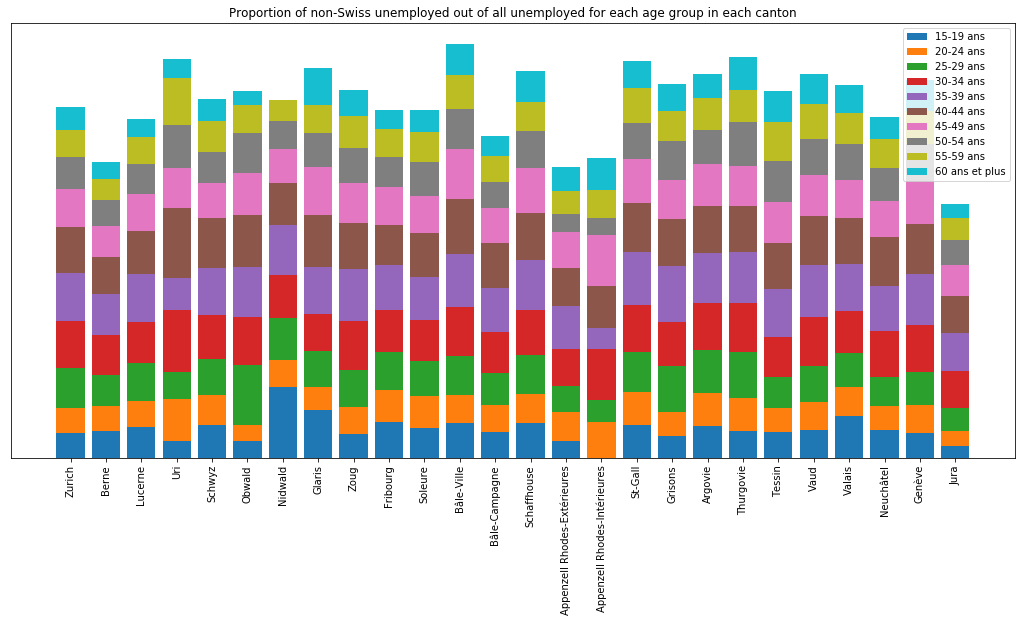

In [20]:
# Number of unemployed grouped by canton, nationality and age category
swiss_age_nat = pd.read_excel(DATA_FOLDER+'/Unemployed_job_seekers_by_month_by_age_by_nationality_clean.xlsx')
swiss_age_nat = swiss_age_nat.replace("...",np.NaN)

swiss_age_nat = swiss_age_nat.apply(pd.to_numeric,errors='ignore')
swiss_age_nat = swiss_age_nat.set_index(['Canton','Nationality','Age group'])


cantons = list(swiss_age_nat.index.get_level_values(0).unique())
age_groups = list(swiss_age_nat.index.get_level_values(2).unique())
tuples = list(zip(cantons,age_groups))
index = pd.MultiIndex.from_product([cantons,age_groups],names=['Canton','Age group'])
september_data = pd.DataFrame(data=[np.nan]*260,index=index)
september_data.columns = ['Value']


for canton in swiss_age_nat.index.get_level_values(0).unique():
    for age in swiss_age_nat.index.get_level_values(2).unique():
        non_swiss = swiss_age_nat.xs(canton).xs('Etrangers').xs(age)['Septembre 2017']
        swiss = swiss_age_nat.xs(canton).xs('Suisses').xs(age)['Septembre 2017']
        september_data.loc[canton,age]['Value'] = non_swiss/(swiss+non_swiss)


plt.figure(figsize=(18,8))
ind = np.arange(26)
previous_data = [0.0]*26
for age in age_groups:
    data_list = []
    for canton in cantons:
        data_list.append(september_data.loc[canton,age]['Value'])
    p1 = plt.bar(ind,data_list,bottom=previous_data)
    p1.set_label(age)
    previous_data = list(np.array(data_list) + np.array(previous_data))
        
plt.legend()
plt.xticks(ind,cantons,rotation=90)
ax = plt.gca()
ax.yaxis.set_visible(False)
plt.title('Proportion of non-Swiss unemployed out of all unemployed for each age group in each canton')
plt.show()

**Bonus:** We show the unemployment rates for each age category and each canton without making a distinction between Swiss and non-Swiss to see what is the effect of age alone.

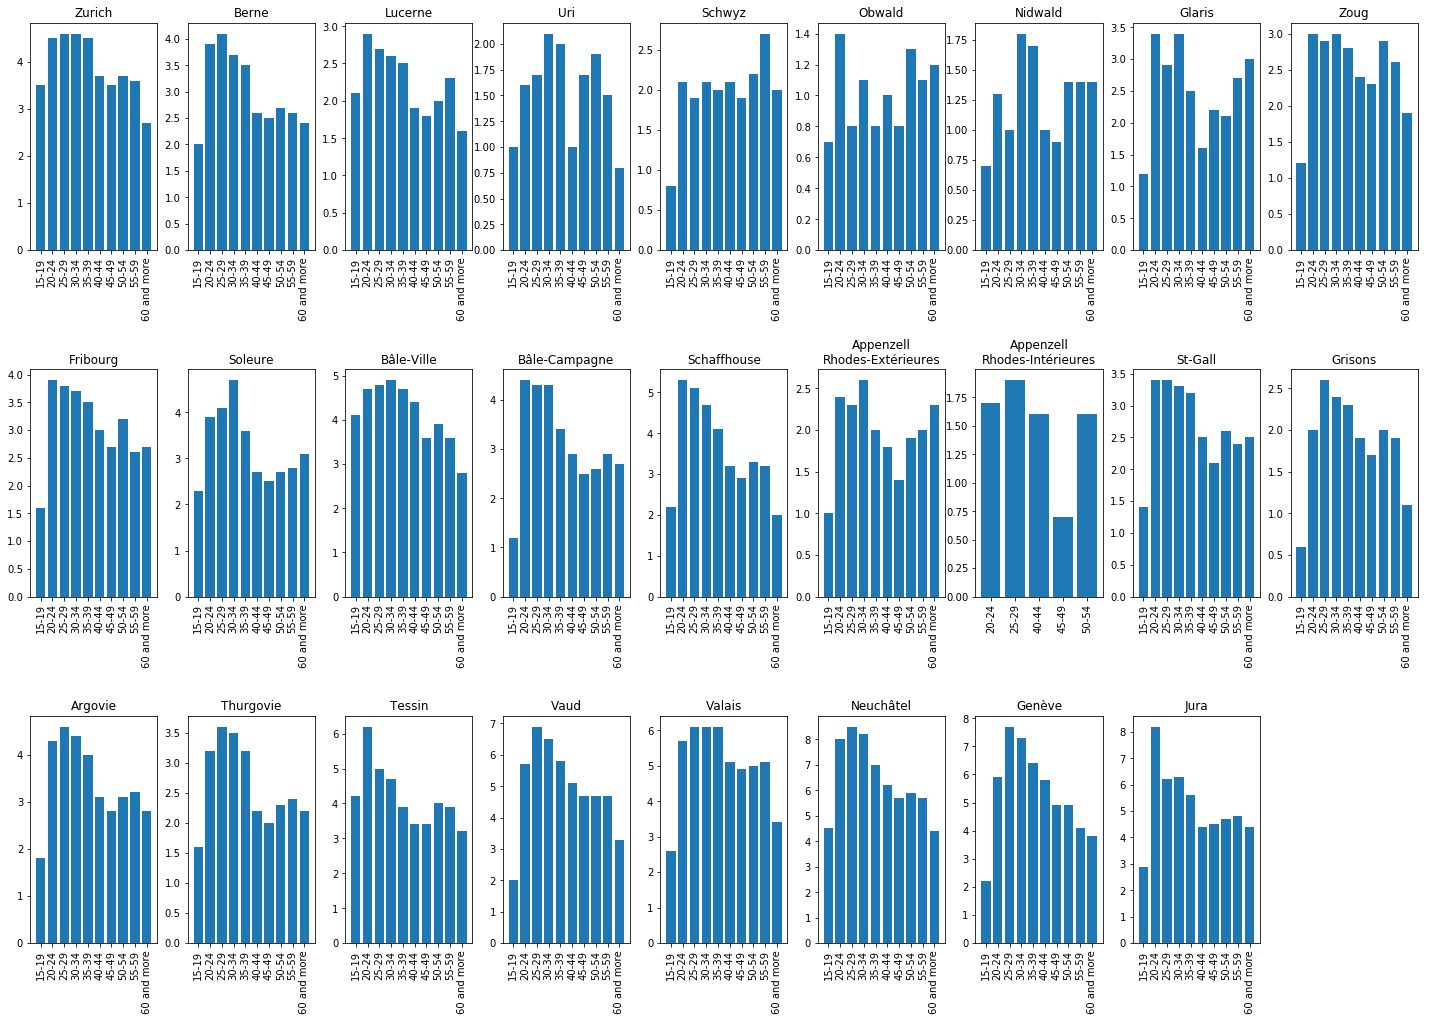

In [21]:
swiss_age = pd.read_excel(DATA_FOLDER+'/Unemployement_rates_by_age_category.xlsx')
swiss_age = swiss_age.replace({"'" : ""},regex=True)
swiss_age = swiss_age.replace("...",np.NaN)
swiss_age

swiss_age = swiss_age.apply(pd.to_numeric,errors='ignore')
swiss_age['Unemployment rate 09.17'].dtype
swiss_age['Unemployment rate 09.17'].apply(pd.to_numeric)
swiss_age = swiss_age[['Canton','Age group','Unemployment rate 01.17']]
swiss_age = swiss_age.set_index(['Canton','Age group'])

fig,axs = plt.subplots(3,9)
fig.set_figwidth(20)
fig.tight_layout()
fig.set_figheight(15)
fig.subplots_adjust(wspace=0.24)
ii = 0
jj = 0
for canton in swiss_age.index.get_level_values(0).unique():
    if ii != 0 and ii % 9 == 0:
        ii = 0
        jj += 1
    plt.sca(axs[jj,ii])
    #swiss_age.xs(canton).dropna().plot.bar()
    values = swiss_age.xs(canton).dropna().values
    labels = swiss_age.xs(canton).dropna().index
    plt.bar(range(len(values)),values)
    plt.xticks(range(len(values)),labels,rotation=90)
    if canton == 'Appenzell Rhodes-Extérieures':
        plt.title('Appenzell\nRhodes-Extérieures')
    elif canton == 'Appenzell Rhodes-Intérieures':
        plt.title('Appenzell\nRhodes-Intérieures')
    else:
        plt.title(canton)
    ii += 1

axs[2,8].axis('off')
plt.show()

# Question 4